In [1]:
import pandas as pd
from datetime import datetime

In [2]:
df = pd.read_csv("D:\code-python\project_practice\server_log\dataframe\data.csv")

In [3]:
df['datetime'] = df['datetime'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z"))

In [4]:
df['error'] = df['status'].apply(lambda x: 1 if x != 200 else 0)

In [5]:
data_grouped = df.resample('15T', on='datetime').agg(
    total_requests=('status', 'count'), 
    total_errors=('error', 'sum')
).reset_index()

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [7]:
data_grouped.set_index('datetime', inplace=True)

In [8]:
train_size = int(len(data_grouped) * 0.8)
train, test = data_grouped[:train_size], data_grouped[train_size:]

# Xây dựng và huấn luyện mô hình SARIMAX
model = SARIMAX(train['total_errors'], 
                order=(1, 1, 1),  # ARIMA(p, d, q)
                seasonal_order=(1, 1, 1, 96),  # SARIMA(P, D, Q, m), 
                enforce_stationarity=False, 
                enforce_invertibility=False)
sarimax_fit = model.fit(disp=False)
# order=(1, 1, 1):
# p: Số bậc tự hồi quy (Auto-Regressive - AR). Mô hình sẽ sử dụng 1 giá trị trước đó để dự đoán.
# d: Số lần lấy sai phân (Integration - I) để biến chuỗi thành chuỗi dừng. Ở đây, chuỗi sẽ lấy sai phân 1 lần.
# q: Số bậc trung bình trượt (Moving Average - MA). Mô hình sử dụng 1 nhiễu trễ để dự đoán.
# seasonal_order=(1, 1, 1, 4):
# P: Số bậc tự hồi quy theo mùa (Seasonal AR).
# D: Số lần lấy sai phân theo mùa (Seasonal Differencing).
# Q: Số bậc trung bình trượt theo mùa (Seasonal MA).

forecast = sarimax_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)
mse = mean_squared_error(test['total_errors'], forecast, squared=False)
forecast.head(), mse

c:\Users\user\miniconda3\envs\test-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\test-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
c:\Users\user\miniconda3\envs\test-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


(2024-12-01 08:00:00+00:00     8.50000
 2024-12-01 08:15:00+00:00    29.75000
 2024-12-01 08:30:00+00:00     7.87500
 2024-12-01 08:45:00+00:00     7.93750
 2024-12-01 09:00:00+00:00    10.96875
 Freq: 15T, Name: predicted_mean, dtype: float64,
 5.928935134262964)

In [9]:
import matplotlib.pyplot as plt

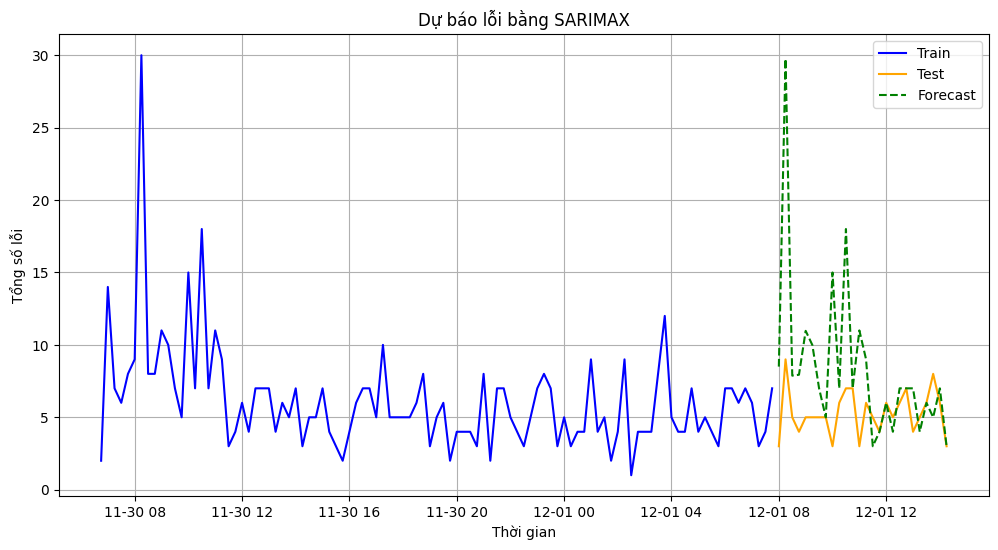

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(train['total_errors'], label='Train', color='blue')
plt.plot(test['total_errors'], label='Test', color='orange')
plt.plot(forecast, label='Forecast', color='green', linestyle='--')
plt.title('Dự báo lỗi bằng SARIMAX')
plt.xlabel('Thời gian')
plt.ylabel('Tổng số lỗi')
plt.legend()
plt.grid()
plt.show()

In [11]:
df.head()

,Unnamed: 0,remote_address,datetime,method,path,status,bytes_sent,user_agent,day,hour,month,error
0,0,127.0.0.1,2024-11-30 06:51:41+00:00,GET,/status,200,1164,kong-ingress-controller/3.3.1,30,6,11,0
1,1,10.244.3.1,2024-11-30 06:51:42+00:00,GET,/status,200,1165,kube-probe/1.27,30,6,11,0
2,2,10.244.3.1,2024-11-30 06:51:42+00:00,GET,/status/ready,200,19,kube-probe/1.27,30,6,11,0
3,3,127.0.0.1,2024-11-30 06:51:44+00:00,GET,/status,200,1164,kong-ingress-controller/3.3.1,30,6,11,0
4,4,127.0.0.1,2024-11-30 06:51:47+00:00,GET,/status,200,1164,kong-ingress-controller/3.3.1,30,6,11,0


In [12]:
data_grouped.to_csv('D:\code-python\project_practice\server_log\data_group.csv')

LSTM

In [13]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [14]:
time_series_data = data_grouped[['total_requests', 'total_errors']]

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(time_series_data)

In [16]:
def create_sequences(data, seq_length): #tạo ra các chuỗi dữ liệu có độ dài cố định từ bộ dữ liệu đầu vào
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, 0])  # Sử dụng total_requests làm input
        y.append(data[i + seq_length, 1])   # Dự đoán total_errors
    return np.array(X), np.array(y)

# Định nghĩa độ dài chuỗi thời gian
sequence_length = 20

In [17]:
# Tạo các tập dữ liệu cho huấn luyện
X, y = create_sequences(scaled_data, sequence_length)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape thành (samples, time steps, features)
#features = 1 vì chỉ sử dụng total_requests làm đầu vào.

# Chia tập dữ liệu thành train/test (80% train, 20% test)
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [18]:
# Xây dựng mô hình LSTM
model = Sequential([
    LSTM(100, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
    LSTM(100, activation='relu', return_sequences=True),  # Second LSTM block
    LSTM(100, activation='relu'),  # Third LSTM block (return_sequences=False by default)
    Dense(1)  # Final dense layer for output
])
model.compile(optimizer='adam', loss='mse')

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)
# epochs=20: Mô hình sẽ lặp qua toàn bộ dữ liệu huấn luyện 20 lần.
# batch_size=16: Cập nhật trọng số sau mỗi 16 mẫu dữ liệu.
# validation_data: Dùng tập kiểm tra để đánh giá mô hình sau mỗi epoch.

# Dự đoán trên tập test
predicted_errors = model.predict(X_test)

# Đưa dữ liệu dự đoán về giá trị gốc (không chuẩn hóa)
predicted_errors_original = scaler.inverse_transform(np.hstack((np.zeros((len(predicted_errors), 1)), predicted_errors)))

predicted_errors_original[:5]

Epoch 1/20
2/2 [==============================] - 5s 564ms/step - loss: 0.0241 - val_loss: 0.0121
Epoch 2/20
2/2 [==============================] - 0s 120ms/step - loss: 0.0129 - val_loss: 0.0037
Epoch 3/20
2/2 [==============================] - 0s 85ms/step - loss: 0.0061 - val_loss: 0.0033
Epoch 4/20
2/2 [==============================] - 0s 83ms/step - loss: 0.0061 - val_loss: 0.0048
Epoch 5/20
2/2 [==============================] - 0s 83ms/step - loss: 0.0072 - val_loss: 0.0027
Epoch 6/20
2/2 [==============================] - 0s 88ms/step - loss: 0.0054 - val_loss: 0.0021
Epoch 7/20
2/2 [==============================] - 0s 83ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 8/20
2/2 [==============================] - 0s 87ms/step - loss: 0.0052 - val_loss: 0.0028
Epoch 9/20
2/2 [==============================] - 0s 88ms/step - loss: 0.0053 - val_loss: 0.0025
Epoch 10/20
2/2 [==============================] - 0s 84ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 11/20
2/2 [==========

array([[158.        ,   5.42412665],
       [158.        ,   5.42443261],
       [158.        ,   5.42194135],
       [158.        ,   5.42044574],
       [158.        ,   5.42098072]])

In [19]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) 

1/1 [==============================] - 0s 46ms/step


In [20]:
from sklearn.metrics import mean_absolute_percentage_error

In [21]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [22]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.002123028039932251
Test MAPE: 0.32456346719618484
Test Accuracy: 0.6754365328038152


In [23]:
# Chuyển đổi y_test và y_pred thành mảng 2D
y_test_reshaped = y_test.reshape(-1, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)

# Đưa về giá trị gốc
y_test_true = scaler.inverse_transform(np.hstack((np.zeros_like(y_test_reshaped), y_test_reshaped)))[:, 1]
y_test_pred = scaler.inverse_transform(np.hstack((np.zeros_like(y_pred_reshaped), y_pred_reshaped)))[:, 1]

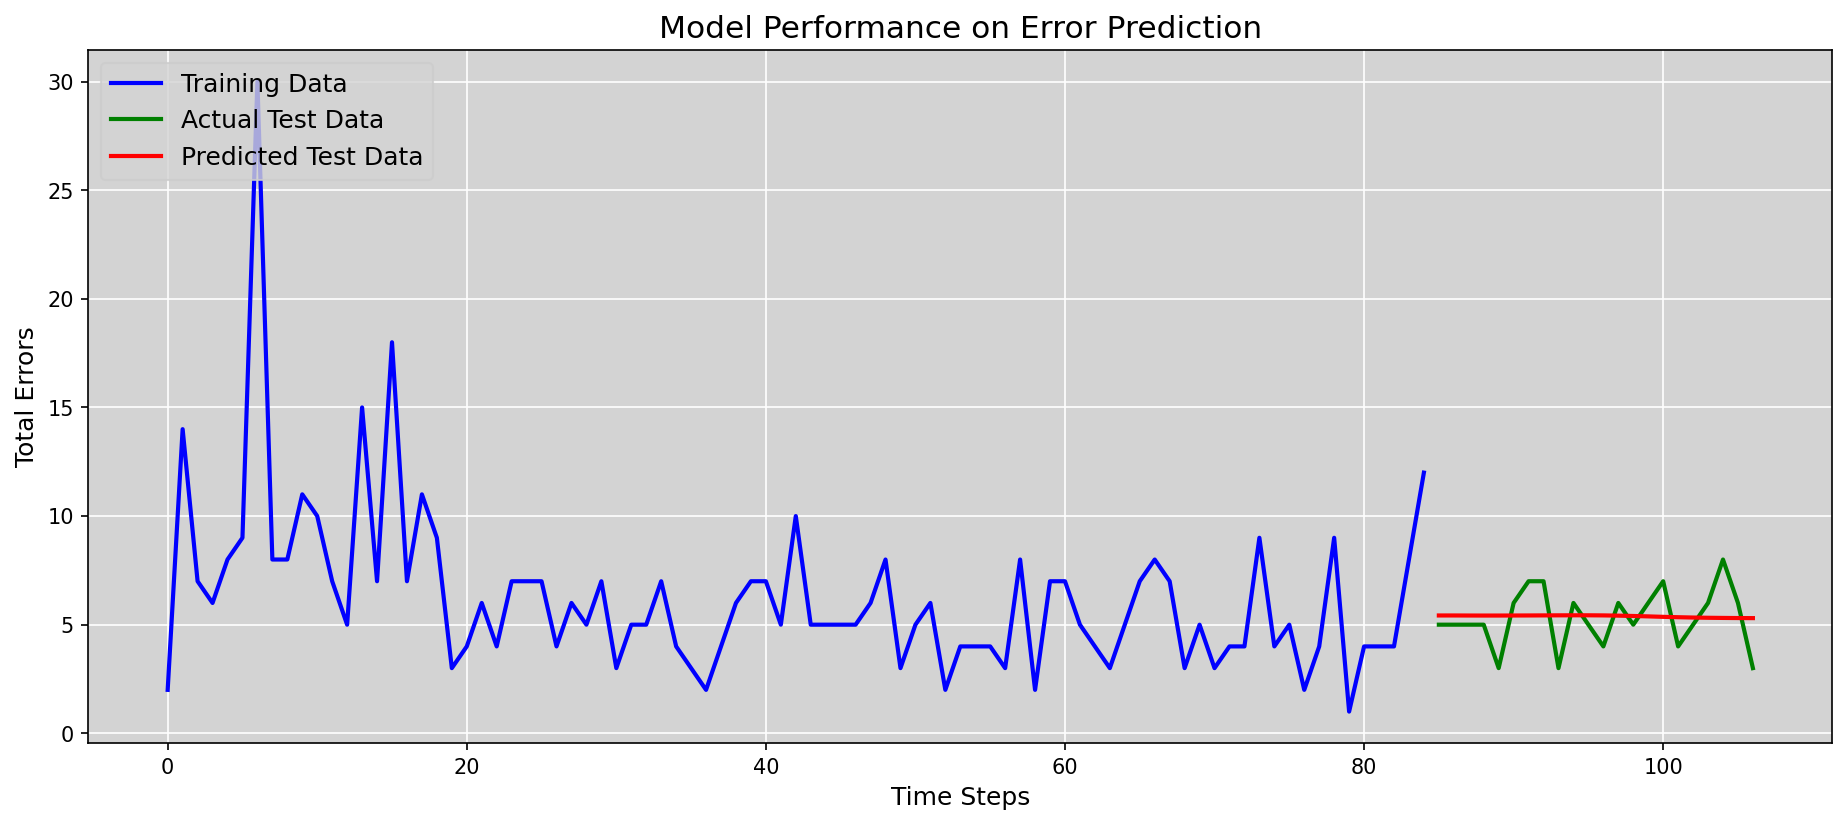

In [24]:
plt.figure(figsize=(15, 6), dpi=150)

plt.rcParams['axes.facecolor'] = 'lightgrey'
plt.rc('axes', edgecolor='black')

# Vẽ dữ liệu huấn luyện (train)
train_indices = range(split_index)
plt.plot(train_indices, scaler.inverse_transform(scaled_data[:split_index, :])[:, 1], color='blue', lw=2, label="Training Data")

# Vẽ dữ liệu thực tế kiểm tra (test)
test_indices = range(split_index, split_index + len(y_test_true))
plt.plot(test_indices, y_test_true, color='green', lw=2, label="Actual Test Data")

# Vẽ dữ liệu dự đoán
plt.plot(test_indices, y_test_pred, color='red', lw=2, label="Predicted Test Data")

# Tùy chỉnh biểu đồ
plt.title('Model Performance on Error Prediction', fontsize=15)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Total Errors', fontsize=12)
plt.legend(loc='upper left', prop={'size': 12})
plt.grid(color='white')

plt.show()